In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

In [3]:
# Load the dataset
df = pd.read_excel('Rotten_Tomatoes_Movies3.xls')

# Display basic information about the dataset
print("\nDataset Info:\n")
df.info()

# Display the first 5 rows of the dataset
print("\nFirst 5 rows of the dataset:\n")
print(df.head())



Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-

In [5]:
# Check for missing values in the target column 'audience_rating'
missing_target = df['audience_rating'].isnull().sum()
print(f"\nMissing values in 'audience_rating': {missing_target}")

# Replace missing values in 'audience_rating' with 'tomatometer_rating' if 'audience_rating' is NaN
df['audience_rating'] = df['audience_rating'].fillna(df['tomatometer_rating'])

# Check if missing values are still present
missing_target_after = df['audience_rating'].isnull().sum()
print(f"\nMissing values in 'audience_rating' after filling: {missing_target_after}")



Missing values in 'audience_rating': 252

Missing values in 'audience_rating' after filling: 0


In [7]:
# Separate features and target
X = df.drop(columns=['audience_rating'])
y = df['audience_rating']

In [15]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'datetime64', 'datetime']).columns

# Convert all categorical features to strings
for col in categorical_features:
    X[col] = X[col].astype(str)

# Preprocessing for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to try
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR()
}

# Store model results in a list
results_list = []


In [27]:
# Train and evaluate each model
import time
import warnings
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    try:
        print(f"\n🚀 Training {name}...")

        # Measure start time
        start_time = time.time()
        
        # Create the pipeline with preprocessing and the current model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Fit the model
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            pipeline.fit(X_train, y_train)

        # Measure end time
        end_time = time.time()
        training_time = end_time - start_time
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Print the model's metrics
        print(f"📈 {name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, Time: {training_time:.2f}s")
        
        # Store the model results
        results_list.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Time (s)': training_time})
        
    except Exception as e:
        print(f"⚠️ Error training {name}: {e}")

# Convert the list of results into a DataFrame
results = pd.DataFrame(results_list)

# # Sort by R2 score (highest to lowest) if R2 exists
# if 'R2' in results.columns:
#     results_sorted = results.sort_values(by='R2', ascending=False)
# else:
#     print("\n⚠️ No valid R2 scores found for any models.")
#     results_sorted = results

# Sort by R2 score (highest to lowest)
results_sorted = results.sort_values(by='R2', ascending=False)

# Display the results
print("\n📊 Final Model Comparison Results")
print(results_sorted)


🚀 Training Linear Regression...
📈 Linear Regression - MAE: 11.0227, RMSE: 14.0328, R2: 0.5322, Time: 0.84s

🚀 Training Decision Tree...
📈 Decision Tree - MAE: 13.9324, RMSE: 18.0624, R2: 0.2249, Time: 9.05s

🚀 Training Random Forest...
📈 Random Forest - MAE: 11.4201, RMSE: 14.6366, R2: 0.4910, Time: 516.42s

🚀 Training Gradient Boosting...
📈 Gradient Boosting - MAE: 11.4162, RMSE: 14.3079, R2: 0.5137, Time: 13.25s

🚀 Training XGBoost...
📈 XGBoost - MAE: 11.1813, RMSE: 14.1083, R2: 0.5271, Time: 5.64s

🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 13310, number of used features: 287
[LightGBM] [Info] Start training from score 60.576559
📈 LightGBM - MAE: 11.0727, RMSE: 13.9887, R2: 0.5351, Time: 1

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19708\2925353396.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=results_sorted, palette='viridis')


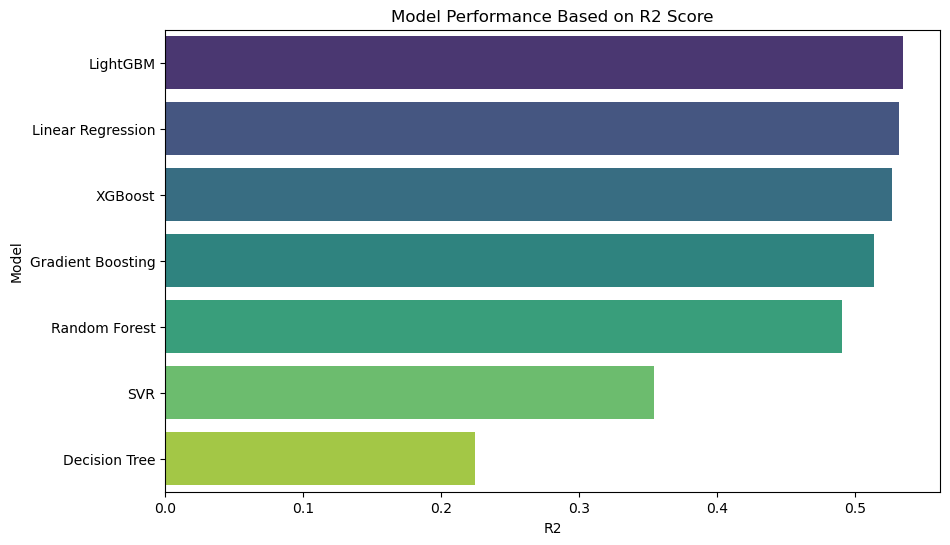

In [29]:
# Visualize the performance of different models if the 'R2' column exists
if 'R2' in results_sorted.columns and not results_sorted.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='R2', y='Model', data=results_sorted, palette='viridis')
    plt.title('Model Performance Based on R2 Score')
    plt.show()